First the program checks to see if the entire image set is accessible.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import pandas as pd
from glob import glob


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/input/.DS_Store
kaggle/input/135/03/135_F_GA28_BW1170_PA38_DG9_PF0_D2_S03_12.jpg
kaggle/input/135/03/135_F_GA28_BW1170_PA38_DG9_PF0_D2_S03_13.jpg
kaggle/input/135/03/135_F_GA28_BW1170_PA38_DG9_PF0_D2_S03_11.jpg
kaggle/input/135/03/135_F_GA28_BW1170_PA38_DG9_PF0_D2_S03_10.jpg
kaggle/input/135/03/135_F_GA28_BW1170_PA38_DG9_PF0_D2_S03_14.jpg
kaggle/input/135/03/135_F_GA28_BW1170_PA38_DG9_PF0_D2_S03_15.jpg
kaggle/input/135/03/135_F_GA28_BW1170_PA38_DG9_PF0_D2_S03_17.jpg
kaggle/input/135/03/135_F_GA28_BW1170_PA38_DG9_PF0_D2_S03_16.jpg
kaggle/input/135/03/135_F_GA28_BW1170_PA38_DG9_PF0_D2_S03_9.jpg
kaggle/input/135/03/135_F_GA28_BW1170_PA38_DG9_PF0_D2_S03_8.jpg
kaggle/input/135/03/135_F_GA28_BW1170_PA38_DG9_PF0_D2_S03_3.jpg
kaggle/input/135/03/135_F_GA28_BW1170_PA38_DG9_PF0_D2_S03_2.jpg
kaggle/input/135/03/135_F_GA28_BW1170_PA38_DG9_PF0_D2_S03_1.jpg
kaggle/input/135/03/135_F_GA28_BW1170_PA38_DG9_PF0_D2_S03_5.jpg
kaggle/input/135/03/135_F_GA28_BW1170_PA38_DG9_PF0_D2_S03_4.jpg
kaggle/in

Extracts the metadata from each image which includes: "ID", "SEX", "GESTATIONAL AGE", "BIRTH WEIGHT", "POSTCONCEPTUAL AGE", "DIAGNOSIS CODE", "PLUS FORM", "DEVICE", "SERIE NUMBER". Later usage of the dataframe is not yet implemented, however this is included to show that it is possible to use this metadata.  

In [2]:
DATA_DIR = 'kaggle/input/retinal-image-dataset-of-infants-and-rop'
IMAGES_DIR = os.path.join(DATA_DIR, 'images_stack_without_captions')
METADATA_PATH = os.path.join(DATA_DIR, 'infant_retinal_database_info.csv')
print(METADATA_PATH)
# --- Metadata ---
try:
    metadata_df = pd.read_csv(METADATA_PATH, sep=";")
    print(" Metadata loaded successfully")
    print(f"Metadata shape: {metadata_df.shape}")
    print("Metadata columns:", list(metadata_df.columns))
except Exception as e:
    print(" Metadata not found or could not be parsed:", e)
    metadata_df = None

kaggle/input/retinal-image-dataset-of-infants-and-rop/infant_retinal_database_info.csv
 Metadata loaded successfully
Metadata shape: (484, 9)
Metadata columns: ['ID ', ' SEX', ' GESTATIONAL AGE (GA)', ' BIRTH WEIGHT (BW)', ' POSTCONCEPTUAL AGE (PA)', ' DIAGNOSIS CODE (DG)', ' PLUS FORM (PF)', ' DEVICE (D)', ' SERIE NUMBER (S)']


Searches through all folders under kaggle/input. Shows the total number of images found.

In [3]:
image_files = glob(os.path.join(IMAGES_DIR, "**", "*.jpg"), recursive=True)

if len(image_files) == 0:
    print(f" No images found in {IMAGES_DIR}")
    print("Checking available subdirectories in dataset root:")
    print(os.listdir(DATA_DIR))
else:
    print(f"\n Total images found: {len(image_files)}")
    print("Sample filenames:")
    for i, filename in enumerate(image_files[:5]):
        print(f"  {i+1}. {os.path.basename(filename)}")


 Total images found: 6004
Sample filenames:
  1. 139_F_GA24_BW550_PA35_DG3_PF2_D2_S05_20.jpg
  2. 162_F_GA26_BW850_PA38_DG4_PF0_D3_S02_23.jpg
  3. 052_M_GA26_BW820_PA33_DG3_PF0_D1_S03_2.jpg
  4. 183_F_GA32_BW1150_PA42_DG0_PF0_D3_S01_17.jpg
  5. 131_M_GA32_BW1480_PA34_DG0_PF0_D2_S01_2.jpg


Uses the file name of each image to find the diagnosis code and converts it to either a 1 (has ROP) or a 0 (does not have ROP).

In [4]:
def parse_diagnosis_from_filename(filename: str):
    """
    Extract diagnosis code (DG) from filename.
    Format:
    PatientID_Sex_GA##_BW####_PA##_DG#_PF#_Device_Series_ImageNum.jpg
    """
    try:
        parts = os.path.basename(filename).split('_')
        for part in parts:
            if part.startswith('DG'):
                return int(part[2:])  # number after 'DG'
        return None
    except Exception as e:
        print(f"Could not parse diagnosis from {filename}: {e}")
        return None

def convert_to_binary_label(diagnosis_code: int):
    """
    Convert multi-class diagnosis to binary:
    - DG0 → 0 (No ROP)
    - DG1, DG2, ... → 1 (ROP present)
    """
    if diagnosis_code is None:
        return None
    return 0 if diagnosis_code == 0 else 1


# --- Process all files ---
diagnoses, binary_labels, valid_files = [], [], []

for filepath in image_files:
    diagnosis = parse_diagnosis_from_filename(filepath)
    if diagnosis is not None:
        binary_label = convert_to_binary_label(diagnosis)
        diagnoses.append(diagnosis)
        binary_labels.append(binary_label)
        valid_files.append(filepath)

print(f" Successfully parsed {len(valid_files)} images with labels")

 Successfully parsed 6004 images with labels


Builds a dataframe mapping each image to its filepath, origional_diagnosis and binary_label. It then shows the distribution between ROP and non ROP images.

In [5]:
df = pd.DataFrame({
    'filepath': valid_files,
    'original_diagnosis': diagnoses,
    'binary_label': binary_labels
})

print(df.head())
print("\nClass distribution:")
print(df['binary_label'].value_counts())

                                            filepath  original_diagnosis  \
0  kaggle/input/retinal-image-dataset-of-infants-...                   3   
1  kaggle/input/retinal-image-dataset-of-infants-...                   4   
2  kaggle/input/retinal-image-dataset-of-infants-...                   3   
3  kaggle/input/retinal-image-dataset-of-infants-...                   0   
4  kaggle/input/retinal-image-dataset-of-infants-...                   0   

   binary_label  
0             1  
1             1  
2             1  
3             0  
4             0  

Class distribution:
binary_label
1    3024
0    2980
Name: count, dtype: int64


Creates a histogram of the relationship between each diagnosis the the amount of images with that diagnosis.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print(" CLASS DISTRIBUTION ANALYSIS")
print("="*50)

# --- Original multi-class distribution ---
print("Original Diagnosis Codes:")
original_dist = pd.Series(diagnoses).value_counts().sort_index()

for code, count in original_dist.items():
    percentage = (count / len(diagnoses)) * 100
    bar = "█" * int(percentage // 2)  # proportional text bar
    print(f"Diagnosis {code:2d}: {count:5d} images ({percentage:5.1f}%) {bar}")

print(f"\nTotal labeled images: {len(diagnoses)}")

 CLASS DISTRIBUTION ANALYSIS
Original Diagnosis Codes:
Diagnosis  0:  2980 images ( 49.6%) ████████████████████████
Diagnosis  1:    45 images (  0.7%) 
Diagnosis  2:   252 images (  4.2%) ██
Diagnosis  3:   458 images (  7.6%) ███
Diagnosis  4:   125 images (  2.1%) █
Diagnosis  8:   470 images (  7.8%) ███
Diagnosis  9:   379 images (  6.3%) ███
Diagnosis 10:    72 images (  1.2%) 
Diagnosis 11:  1061 images ( 17.7%) ████████
Diagnosis 12:    48 images (  0.8%) 
Diagnosis 13:   114 images (  1.9%) 

Total labeled images: 6004


Calculates the imbalance ratio between ROP and non ROP images and then evaulates to see if the imbalance_ratio is low enough to continue moving forward.

In [7]:
binary_dist = pd.Series(binary_labels).value_counts().sort_index()
print("\nBINARY CLASSIFICATION DISTRIBUTION:")

for label, count in binary_dist.items():
    percentage = (count / len(binary_labels)) * 100
    label_name = "No ROP (0)" if label == 0 else "ROP Present (1)"
    print(f"{label_name:13}: {count:5d} images ({percentage:5.1f}%)")

# --- Imbalance ratio ---
imbalance_ratio = (binary_dist[0] / binary_dist[1]) if 1 in binary_dist else float('inf')
print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1 (Normal : ROP)")

# --- Severity assessment ---
if imbalance_ratio > 10:
    severity, color = "SEVERE", "🔴"
elif imbalance_ratio > 3:
    severity, color = "MODERATE", "🟡"
else:
    severity, color = "MILD", "🟢"

print(f"{color} Class imbalance severity: {severity}")



BINARY CLASSIFICATION DISTRIBUTION:
No ROP (0)   :  2980 images ( 49.6%)
ROP Present (1):  3024 images ( 50.4%)

Imbalance ratio: 0.99:1 (Normal : ROP)
🟢 Class imbalance severity: MILD


Creates a plot showing the class and multi-class distribution.

/var/folders/5b/dt63jtmj6xdcpycyvf46wymr0000gn/T/ipykernel_34071/437527729.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=original_dist.index, y=original_dist.values, palette="Blues")


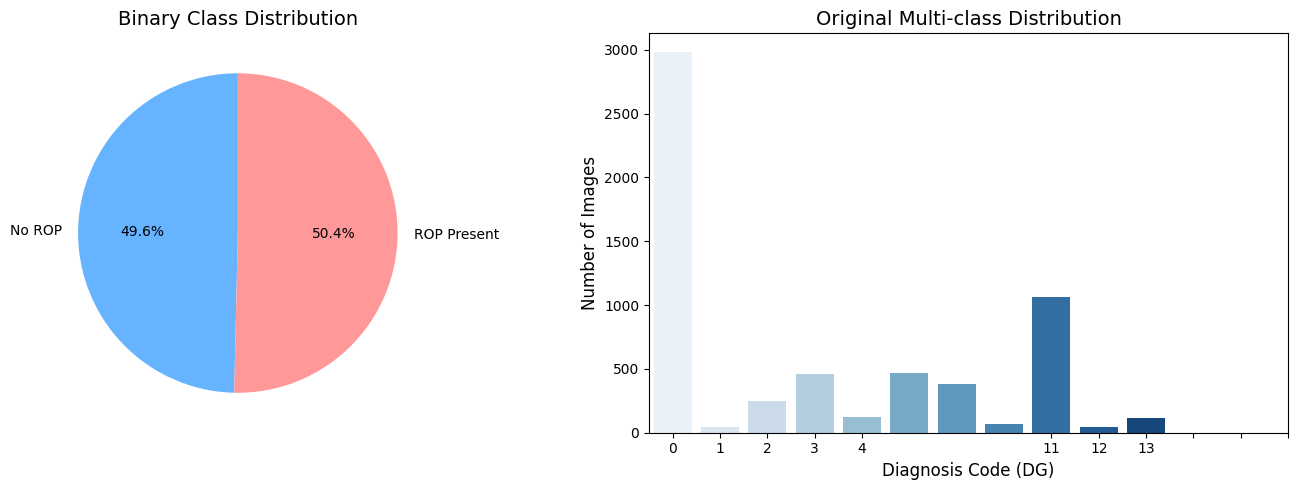

In [8]:
plt.figure(figsize=(14, 5))

# Binary distribution pie chart
plt.subplot(1, 2, 1)
labels = ['No ROP', 'ROP Present']
colors = ['#66b3ff', '#ff9999']
plt.pie(binary_dist.values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Binary Class Distribution', fontsize=14)

# Original multi-class bar plot
plt.subplot(1, 2, 2)
sns.barplot(x=original_dist.index, y=original_dist.values, palette="Blues")
plt.xlabel('Diagnosis Code (DG)', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Original Multi-class Distribution', fontsize=14)
plt.xticks(original_dist.index)

plt.tight_layout()
plt.show()

Resizes and color grades each image. This first works by converting the input image from the RGB color space to the LAB color space. Instead of Red, Green, and Blue defining a pixel it is now defined by L(Lightness) A(Green-Red) B(Blue-Yellow). It then creates a CLAHE object with a clipLimit = 3 and a tileGridSize = (8,8). This limits the contrast enhancement to avoid over-amplifying noise and divides the image into 8x8 tiles for local histogram equalization. It then applies this CLAHE object to the L channel. The modified L channel is then merged back with the origional A and B channels to complete the final image. The last step is converting the LAB image back into the RGB color space. This full color grading is designed to improve contrast while preserving the original color information.

It then shows an image of non enhanced vs enhanced images.

 Displaying Sample Images
Sample 1: kaggle/input/retinal-image-dataset-of-infants-and-rop/images_stack_without_captions/139_F_GA24_BW550_PA35_DG3_PF2_D2_S05_20.jpg
Sample 2: kaggle/input/retinal-image-dataset-of-infants-and-rop/images_stack_without_captions/084_M_GA27_BW990_PA36_DG9_PF0_D2_S04_10.jpg
Sample 3: kaggle/input/retinal-image-dataset-of-infants-and-rop/images_stack_without_captions/171_M_GA31_BW1750_PA41_DG0_PF0_D3_S02_6.jpg
Sample 4: kaggle/input/retinal-image-dataset-of-infants-and-rop/images_stack_without_captions/133_F_GA41_BW3620_PA42_DG0_PF0_D2_S01_1.jpg
Sample 5: kaggle/input/retinal-image-dataset-of-infants-and-rop/images_stack_without_captions/139_F_GA24_BW550_PA35_DG3_PF2_D2_S05_46.jpg
Sample 6: kaggle/input/retinal-image-dataset-of-infants-and-rop/images_stack_without_captions/103_M_GA27_BW1050_PA34_DG0_PF0_D2_S03_2.jpg
Sample 7: kaggle/input/retinal-image-dataset-of-infants-and-rop/images_stack_without_captions/001_F_GA41_BW2905_PA50_DG11_PF0_D1_S03_1.jpg
Sample 

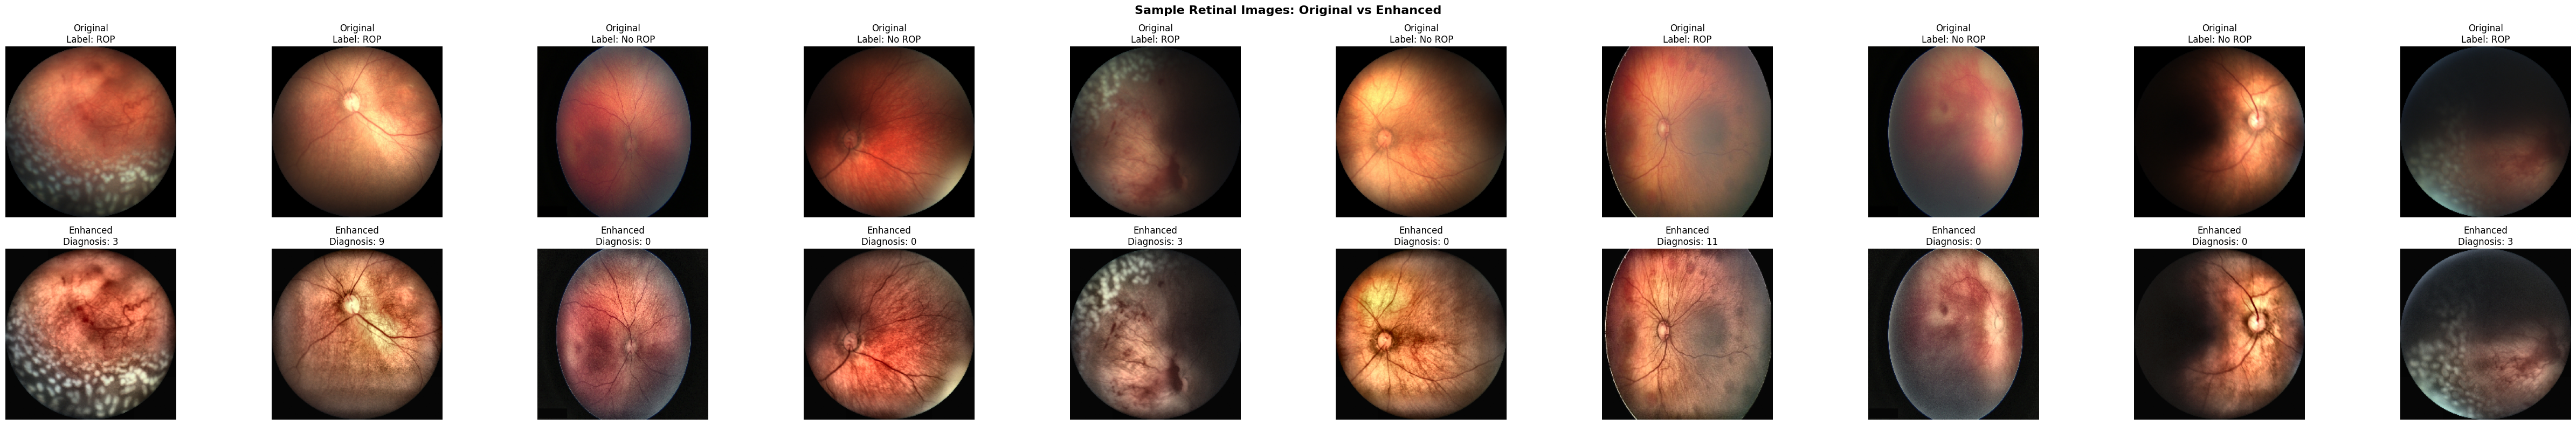

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_and_preprocess_image(image_path, target_size=(224, 224), enhance=True):
    """
    Load and preprocess a retinal image with optional medical-specific enhancements.
    
    Args:
        image_path (str): Path to the input image.
        target_size (tuple): Desired image size (width, height).
        enhance (bool): Whether to apply medical-specific enhancements.
    
    Returns:
        np.ndarray or None: Preprocessed image as float32 in [0, 1], or None if loading fails.
    """
    try:
        # Load image
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if img is None:
            return None

        # Convert BGR → RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Medical enhancement (Contrast Limited Adaptive Histogram Equalization - CLAHE)
        if enhance:
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
            l = clahe.apply(l)
            lab = cv2.merge((l, a, b))
            img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

        # Resize and normalize
        img = cv2.resize(img, target_size)
        img = img.astype(np.float32) / 255.0

        return img

    except Exception as e:
        print(f" Error processing {image_path}: {e}")
        return None


def show_sample_images(df, n_samples=3):
    """
    Display sample images (original vs enhanced) for quick quality check.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'filepath', 'binary_label', 'original_diagnosis'.
        n_samples (int): Number of sample images to display (default=3).
    """
    print(" Displaying Sample Images")
    print("=" * 50)

    # Select first, middle, and last indices
    sample_indices = [0, len(df) // 2, -1] if n_samples == 3 else np.linspace(0, len(df)-1, n_samples, dtype=int)
    
    fig, axes = plt.subplots(2, len(sample_indices), figsize=(5 * len(sample_indices), 8))

    for i, idx in enumerate(sample_indices):
        row = df.iloc[idx]
        print(f"Sample {i+1}: {row['filepath']}")
        img = load_and_preprocess_image(row['filepath'], enhance=False)
        img_enhanced = load_and_preprocess_image(row['filepath'], enhance=True)

        if img is not None and img_enhanced is not None:
            # Original
            axes[0, i].imshow(img)
            axes[0, i].set_title(f"Original\nLabel: {['No ROP','ROP'][row['binary_label']]}")
            axes[0, i].axis("off")

            # Enhanced
            axes[1, i].imshow(img_enhanced)
            axes[1, i].set_title(f"Enhanced\nDiagnosis: {row['original_diagnosis']}")
            axes[1, i].axis("off")
        else:
            axes[0, i].text(0.5, 0.5, "Load Failed", ha="center", va="center")
            axes[1, i].text(0.5, 0.5, "Load Failed", ha="center", va="center")

    plt.suptitle("Sample Retinal Images: Original vs Enhanced", fontsize=16, weight="bold")
    plt.tight_layout()
    plt.show()


# Run test visualization
show_sample_images(df, n_samples=10)

In [10]:
def add_gaussian_noise(img, mean=0.0, std=0.01):
    noise = np.random.normal(mean, std, img.shape)
    noisy_img = np.clip(img + noise, 0., 1.)
    return noisy_img

In [11]:
print(" IMPLEMENTING CLASS IMBALANCE SOLUTIONS")
print("="*50)

#  Required imports
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# Solution 1: Calculate class weights
def calculate_class_weights(y_binary, strategy='medical'):
    """
    Calculate class weights for imbalanced medical data.
    MEDICAL strategy:
        - ROP (positive class) gets HIGHER weight
        - No ROP (negative class) gets LOWER weight
        - Weight ratio = (majority/minority) * medical_factor
    """
    class_counts = np.bincount(y_binary)

    if strategy == 'balanced':
        weights = compute_class_weight('balanced', classes=[0,1], y=y_binary)

    elif strategy == 'medical':
        # Identify majority and minority
        majority = max(class_counts)
        minority = min(class_counts)

        # MEDICAL emphasis multiplier
        medical_factor = 2.0

        weight_no_rop = 1.0
        weight_rop = (majority / minority) * medical_factor

        weights = np.array([weight_no_rop, weight_rop])

    weight_dict = {0: weights[0], 1: weights[1]}

    print(f"Class weights ({strategy} strategy):")
    print(f"  No ROP (0):      {weight_dict[0]:.3f}")
    print(f"  ROP Present (1): {weight_dict[1]:.3f}")
    print(f"  → ROP cases weighted {weight_dict[1]/weight_dict[0]:.1f}x higher")

    return weight_dict

# Calculate medical-focused class weights
class_weights = calculate_class_weights(binary_labels, strategy='medical')

 IMPLEMENTING CLASS IMBALANCE SOLUTIONS
Class weights (medical strategy):
  No ROP (0):      1.000
  ROP Present (1): 2.030
  → ROP cases weighted 2.0x higher


In [12]:
print(f"\n STRATIFIED DATA SPLITTING")
print("-"*30)

X_indices = np.arange(len(df))
y_binary = np.array(binary_labels)

# First split: Train vs Test (80/20)
train_idx, test_idx, y_train, y_test = train_test_split(
    X_indices, y_binary,
    test_size=0.2,
    stratify=y_binary,
    random_state=42
)

# Second split: Train vs Validation (64/16/20 total)
train_idx, val_idx, y_train_split, y_val = train_test_split(
    train_idx, y_train,
    test_size=0.2,  # 20% of remaining 80% = 16% of total
    stratify=y_train,
    random_state=42
)

print("Data split completed:")
print(f"Training:   {len(train_idx):4d} samples ({len(train_idx)/len(df)*100:4.1f}%)")
print(f"Validation: {len(val_idx):4d} samples ({len(val_idx)/len(df)*100:4.1f}%)")
print(f"Testing:    {len(test_idx):4d} samples ({len(test_idx)/len(df)*100:4.1f}%)")

# Check class distribution in each split
for split_name, split_labels in [("Training", y_train_split), ("Validation", y_val), ("Testing", y_test)]:
    split_dist = np.bincount(split_labels)
    rop_percentage = split_dist[1] / len(split_labels) * 100
    print(f"{split_name}: {split_dist[0]} No ROP, {split_dist[1]} ROP ({rop_percentage:.1f}% ROP)")

print("Stratification successful - class ratios maintained across splits")


 STRATIFIED DATA SPLITTING
------------------------------
Data split completed:
Training:   3842 samples (64.0%)
Validation:  961 samples (16.0%)
Testing:    1201 samples (20.0%)
Training: 1907 No ROP, 1935 ROP (50.4% ROP)
Validation: 477 No ROP, 484 ROP (50.4% ROP)
Testing: 596 No ROP, 605 ROP (50.4% ROP)
Stratification successful - class ratios maintained across splits


In [13]:
def pad_with_black(img, pad_ratio=0.15):
    """Pad image on all sides with black pixels."""
    h, w, c = img.shape
    pad_h = int(h * pad_ratio)
    pad_w = int(w * pad_ratio)
    
    return np.pad(
        img,
        ((pad_h, pad_h), (pad_w, pad_w), (0, 0)),
        mode='constant',
        constant_values=0
    )

def load_and_preprocess_image(filepath, target_size=(224,224)):
    """
    Load and preprocess image for augmentation/visualization.
    - Returns uint8 [0,255] for augmentation compatibility
    """
    img = cv2.imread(filepath)
    if img is None:
        return None
    
    # Convert BGR -> RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize
    img = cv2.resize(img, target_size)
    
    #  Keep in uint8 [0,255] for augmentation
    return img

MEDICAL IMAGE AUGMENTATION CONFIGURED
 Small rotations, shifts, zoom, flips, brightness & color adjustments


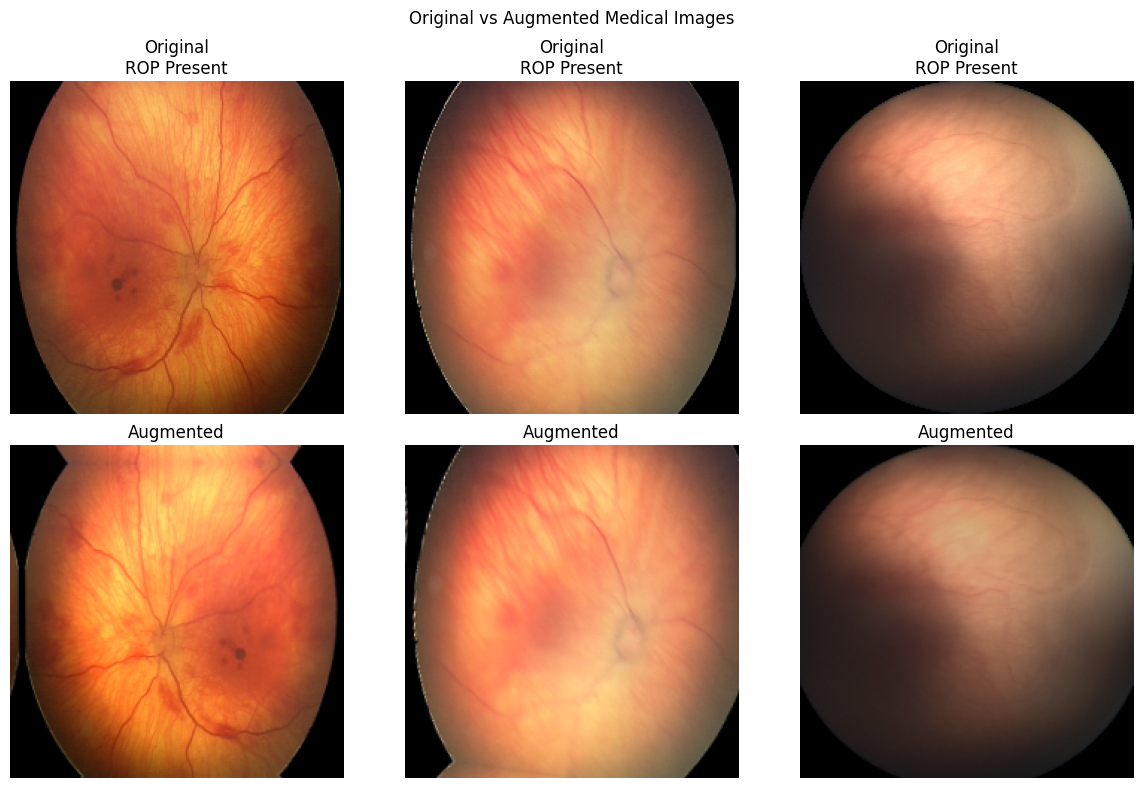

In [14]:
def create_medical_augmentation():
    """
    Augmentation pipeline specific to retinal images.
    """
    augmentation = ImageDataGenerator(
        rotation_range=15,        # Small rotations
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.1,
        horizontal_flip=True,     # Left/right symmetry
        brightness_range=[0.8, 1.2],
        channel_shift_range=0.1,
        fill_mode='reflect',   # <--- force constant background
    )
    return augmentation

# Create augmentation generator
train_augmentation = create_medical_augmentation()

print("MEDICAL IMAGE AUGMENTATION CONFIGURED")
print(" Small rotations, shifts, zoom, flips, brightness & color adjustments")

# --- Visualization helper ---
def show_augmented_samples(df, indices, augmentation, n_samples=3):
    """Show original vs augmented images"""
    fig, axes = plt.subplots(2, n_samples, figsize=(12, 8))
    
    for i in range(n_samples):
        idx = indices[i]
        row = df.iloc[idx]
        
        # Load original
        img = load_and_preprocess_image(row['filepath'])
        if img is None:
            continue
        
        # Original
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'Original\n{["No ROP", "ROP Present"][row["binary_label"]]}')
        axes[0, i].axis('off')
        
        # Augmented
        img_batch = np.expand_dims(img, 0)   # Add batch dim
        aug_iter = augmentation.flow(img_batch, batch_size=1)
        aug_img = next(aug_iter)[0].astype(np.uint8)  # Convert back to uint8
        
        axes[1, i].imshow(aug_img)
        axes[1, i].set_title('Augmented')
        axes[1, i].axis('off')
    
    plt.suptitle('Original vs Augmented Medical Images')
    plt.tight_layout()
    plt.show()

# --- Demo on 3 training images ---
sample_indices = [train_idx[0], train_idx[len(train_idx)//2], train_idx[-1]]
show_augmented_samples(df, sample_indices, train_augmentation)

In [15]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf

# Cell 8: Model Architecture Design
def create_advanced_rop_model(num_classes=2, input_shape=(224, 224, 3)):
    """
    Create ROP classification model with advanced techniques for medical imaging
    """
    
    print(" BUILDING ADVANCED ROP CLASSIFICATION MODEL")
    print("-"*50)
    
    # Base model - EfficientNetB0 (optimal balance for medical images)
    print("1. Base Model: EfficientNetB0")
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Initially freeze base model for transfer learning
    base_model.trainable = False
    print("    Base model FROZEN for initial training")
    
    # Build custom classification head
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    
    # Batch normalization
    x = layers.BatchNormalization()(x)
    
    # Dense block 1
    x = layers.Dense(512, activation='relu',
                     kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)
    
    # Dense block 2
    x = layers.Dense(256, activation='relu',
                     kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.BatchNormalization()(x)
    
    # Dense block 3
    x = layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    
    # Output layer
    predictions = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    
    model = models.Model(inputs=inputs, outputs=predictions)
    
    print(f"\n Model created with {model.count_params():,} total parameters")
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Frozen parameters: {model.count_params() - trainable_params:,}")
    
    return model

# Create the model
rop_model = create_advanced_rop_model()

# Display model architecture
print("\n MODEL ARCHITECTURE SUMMARY:")
rop_model.summary()

 BUILDING ADVANCED ROP CLASSIFICATION MODEL
--------------------------------------------------
1. Base Model: EfficientNetB0
    Base model FROZEN for initial training

 Model created with 4,878,117 total parameters
   Trainable parameters: 824,450
   Frozen parameters: 4,053,667

 MODEL ARCHITECTURE SUMMARY:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,878,117 (18.61 MB)

 Trainable params: 824,450 (3.15 MB)

 Non-trainable params: 4,053,667 (15.46 MB)

In [16]:
print(" ADVANCED TRAINING STRATEGY")
print("="*40)

# ============================
# 1. Custom Callback
# ============================
class MedicalMetricsCallback(tf.keras.callbacks.Callback):
    """Custom callback to monitor medical-specific metrics"""
    
    def on_epoch_end(self, epoch, logs=None):
        if logs:
            val_precision = logs.get('val_precision', 0)
            val_recall = logs.get('val_recall', 0)
            val_auc = logs.get('val_auc', 0)
            
            # Calculate F1 score
            if val_precision + val_recall > 0:
                f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
            else:
                f1_score = 0
            
            print(f"\n Medical Metrics - Epoch {epoch + 1}:")
            print(f"   Precision: {val_precision:.4f} | Recall: {val_recall:.4f}")
            print(f"   F1-Score: {f1_score:.4f} | AUC: {val_auc:.4f}")
            
            # Medical warnings
            if val_recall < 0.7 and epoch > 5:
                print("   LOW RECALL - May miss ROP cases!")
            if val_precision < 0.5 and epoch > 5:
                print("   LOW PRECISION - Too many false alarms!")

# ============================
# 2. Callbacks Setup
# ============================
def create_medical_callbacks():
    """Create callbacks optimized for medical image classification"""
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_auc',
            patience=12,
            restore_best_weights=True,
            mode='max',
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_rop_model.h5',
            monitor='val_auc',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=6,
            min_lr=1e-7,
            verbose=1
        ),
        tf.keras.callbacks.CSVLogger('rop_training_log.csv'),
        MedicalMetricsCallback()
    ]
    return callbacks

# ============================
# 3. Phase 1: Compile model (Frozen Base)
# ============================
print("PHASE 1: Feature Learning with Frozen Base")
print("-"*45)

rop_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# Create callbacks
callbacks = create_medical_callbacks()

print(" Advanced callbacks configured:")
print("   • Early stopping on AUC (medical-appropriate metric)")
print("   • Model checkpointing for best performance")
print("   • Learning rate scheduling")
print("   • Medical metrics monitoring")
print("   • Training history logging")

 ADVANCED TRAINING STRATEGY
PHASE 1: Feature Learning with Frozen Base
---------------------------------------------
 Advanced callbacks configured:
   • Early stopping on AUC (medical-appropriate metric)
   • Model checkpointing for best performance
   • Learning rate scheduling
   • Medical metrics monitoring
   • Training history logging


In [17]:
print(" PREPARING DATA FOR TRAINING")
print("="*35)

# Load all images efficiently
def load_images_batch(df, indices, enhance=True):
    """Load batch of images efficiently"""
    images = []
    labels = []
    
    print(f"Loading {len(indices)} images...")
    for i, idx in enumerate(indices):
        if i % 500 == 0:
            print(f"  Progress: {i}/{len(indices)}")
        
        row = df.iloc[idx]
        img = load_and_preprocess_image(row['filepath'])
        
        if img is not None:
            images.append(img)
            labels.append(row['binary_label'])
        else:
            print(f" Failed to load image: {row['filename']}")
    
    return np.array(images), np.array(labels)

 PREPARING DATA FOR TRAINING


In [18]:
# Load training, validation, and test sets
print("Loading training set...")
X_train, y_train_final = load_images_batch(df, train_idx, enhance=True)

print("Loading validation set...")
X_val, y_val_final = load_images_batch(df, val_idx, enhance=True)

print("Loading test set...")
X_test, y_test_final = load_images_batch(df, test_idx, enhance=True)

print(f"\n Data loading completed:")
print(f"   Training:   {X_train.shape[0]} images, shape: {X_train.shape[1:]}")
print(f"   Validation: {X_val.shape[0]} images, shape: {X_val.shape[1:]}")  
print(f"   Test:       {X_test.shape[0]} images, shape: {X_test.shape[1:]}")

# Verify class distribution
print(f"\nFinal class distribution:")
for split_name, y_split in [("Training", y_train_final), ("Validation", y_val_final), ("Test", y_test_final)]:
    counts = np.bincount(y_split)
    rop_pct = counts[1] / len(y_split) * 100
    print(f"   {split_name}: {counts[0]} No ROP, {counts[1]} ROP ({rop_pct:.1f}%)")
# Labels: 0 or 1, shape (num_samples,)
rop_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# y_train_final should be shape (num_samples,)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc', patience=10, restore_best_weights=True, mode='max', verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        'best_rop_model.h5', monitor='val_auc', save_best_only=True, mode='max', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.CSVLogger('rop_training_log.csv')
]

history = rop_model.fit(
    X_train, y_train_final,
    validation_data=(X_val,y_val_final),
    epochs=5,
    batch_size=32,
    class_weight=class_weights,  # Handles imbalance
    callbacks=callbacks,
    verbose=1
)

Loading training set...
Loading 3842 images...
  Progress: 0/3842
  Progress: 500/3842
  Progress: 1000/3842
  Progress: 1500/3842
  Progress: 2000/3842
  Progress: 2500/3842
  Progress: 3000/3842
  Progress: 3500/3842
Loading validation set...
Loading 961 images...
  Progress: 0/961
  Progress: 500/961
Loading test set...
Loading 1201 images...
  Progress: 0/1201
  Progress: 500/1201
  Progress: 1000/1201

 Data loading completed:
   Training:   3842 images, shape: (224, 224, 3)
   Validation: 961 images, shape: (224, 224, 3)
   Test:       1201 images, shape: (224, 224, 3)

Final class distribution:
   Training: 1907 No ROP, 1935 ROP (50.4%)
   Validation: 477 No ROP, 484 ROP (50.4%)
   Test: 596 No ROP, 605 ROP (50.4%)
Epoch 1/5
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6694 - loss: 12.4009

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_auc available.
  if self._should_save_model(epoch, batch, logs, filepath):


121/121 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7111 - loss: 11.1180 - val_accuracy: 0.7118 - val_loss: 8.4349 - learning_rate: 0.0010
Epoch 2/5
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7594 - loss: 7.6746

121/121 ━━━━━━━━━━━━━━━━━━━━ 52s 428ms/step - accuracy: 0.7522 - loss: 6.8501 - val_accuracy: 0.7503 - val_loss: 5.1372 - learning_rate: 0.0010
Epoch 3/5
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.7908 - loss: 4.7117

121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 424ms/step - accuracy: 0.7933 - loss: 4.2806 - val_accuracy: 0.7732 - val_loss: 3.3181 - learning_rate: 0.0010
Epoch 4/5
 38/121 ━━━━━━━━━━━━━━━━━━━━ 33s 405ms/step - accuracy: 0.7818 - loss: 3.3762

KeyboardInterrupt: 

In [ ]:
#evaluate model
results = rop_model.evaluate(X_test, y_test_final, verbose=1)
print(f"\nTest Results:")
for name, value in zip(rop_model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Confusion matrix and classification report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(rop_model.predict(X_test), axis=1)
y_true = y_test_final
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["No ROP", "ROP Present"]))

In [ ]:
cm = confusion_matrix(y_true, y_pred)
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No ROP", "ROP Present"], yticklabels=["No ROP", "ROP Present"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    'rop_model_best.keras',  # or 'rop_model_best.h5' for HDF5 format
    monitor='val_auc',      # or 'val_loss', 'val_accuracy', .
    save_best_only=True,   # Only save when the metric improves
    mode='max',             # 'max' for AUC/accuracy, 'min' for loss
    verbose=1
)
callbacks = [
    checkpoint_cb,
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=12,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=6,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger('rop_training_log.csv'),
    MedicalMetricsCallback()
]

# Save in the newer Keras v3 format
rop_model.save("rop_final_model.keras")

print("Model saved in .keras format")

In [ ]:
def get_last_conv_layer(model):
    """
    Returns the name of the last Conv2D layer in the model.
    Useful if you don't know the correct layer name.
    """
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
        if hasattr(layer, "layers"):  # nested model (EfficientNet, etc)
            for sub in reversed(layer.layers):
                if isinstance(sub, tf.keras.layers.Conv2D):
                    return sub.name
    raise ValueError("No Conv2D layer found in model.")
get_last_conv_layer(rop_model)


Using gradcam to see the heatmap for which portions of an image lead to each evalutation.

In [ ]:
def generate_gradcam(model, img_array, layer_name="top_conv"):
    """
    Generates a Grad-CAM heatmap for a given model + input image.
    img_array must be shape (1, H, W, 3)
    """

    # Auto-detect last conv layer if none provided
    if layer_name is None:
        layer_name = get_last_conv_layer(model)

    # Build a model that maps input → (conv_layer_output, predictions)
    conv_layer = None
    try:
        conv_layer = model.get_layer(layer_name)
    except:
        # Might be inside a nested model (e.g., EfficientNetB0)
        for layer in model.layers:
            if hasattr(layer, "get_layer"):
                try:
                    conv_layer = layer.get_layer(layer_name)
                except:
                    pass

    if conv_layer is None:
        raise ValueError(f"Conv layer '{layer_name}' not found.")

    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[conv_layer.output, model.output]
    )

    # Forward + backward pass
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    # Gradients of top predicted class wrt conv layer
    grads = tape.gradient(loss, conv_outputs)

    # Channel-wise mean (Grad-CAM weights)
    weights = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
    feature_maps = conv_outputs[0].numpy()

    # Weighted combination of channels
    heatmap = np.dot(feature_maps, weights)

    # Normalize
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + 1e-10)

    return heatmap


Puts heatmap onto the final image

In [ ]:
def overlay_heatmap(img, heatmap, alpha=0.45):
    """
    img: uint8 image (H, W, 3)
    heatmap: float32 (H', W')
    """
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    blended = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)
    return blended


Experimental feature detection

In [ ]:
# Load & preprocess an image
img = load_and_preprocess_image("kaggle/input/003/01/003_F_GA41_BW3950_PA42_DG11_PF0_D1_S01_1.jpg")
img_input = np.expand_dims(img, axis=0)

# Generate heatmap
heatmap = generate_gradcam(rop_model, img_input, layer_name='top_conv')  
# layer_name=None → auto-detect last conv layer

# Create overlay
overlay = overlay_heatmap((img * 255).astype(np.uint8), heatmap)

# Show
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.show()
